In [1]:
using DifferentialEquations
using DiffEqSensitivity
using Random
using Distributions
using DataFrames
using StatsPlots
using Turing
using PlutoUI
using Quadrature
using StatsFuns
using StatsBase

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1273
┌ Info: Precompiling DiffEqSensitivity [41bf760c-e81c-5289-8e54-58b1f1f8abe2]
└ @ Base loading.jl:1273
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1273
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273
┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1273
┌ Info: Precompiling Quadrature [67601950-bd08-11e9-3c89-fd23fb4432d2]
└ @ Base loading.jl:1273


In [2]:
Random.seed!(1234)

MersenneTwister(UInt32[0x000004d2], Random.DSFMT.DSFMT_state(Int32[-1393240018, 1073611148, 45497681, 1072875908, 436273599, 1073674613, -2043716458, 1073445557, -254908435, 1072827086  …  -599655111, 1073144102, 367655457, 1072985259, -1278750689, 1018350124, -597141475, 249849711, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x000000000000

In [3]:
# ╔═╡ bf72c778-f362-11ea-1763-f1c7c2b761fb
function sir_ode!(du,u,p,t)
    (S,I,R,C) = u
    (β,γ) = p
    N = S+I+R
    infection = β*I/N*S
    recovery = γ*I
    @inbounds begin
        du[1] = -infection
        du[2] = infection - recovery
        du[3] = recovery
        du[4] = infection
    end
    nothing
end

# ╔═╡ 851de356-f366-11ea-3bfa-6f28b87378bf
function base_reproduction_rate(β, γ)
    return β / γ
end

# ╔═╡ 97441d98-f50d-11ea-364b-0b9955b8afff
function predict(y,chain)
    # Length of data
    l = length(y)
    # Length of chain
    m = length(chain)
    # Choose random
    idx = sample(1:m)
    i₀ = Array(chain[:i₀])[idx]
    β = Array(chain[:β])[idx]
    I = i₀ * 10.0
    u0=[1000.0-I,I,0.0,0.0]
    p=[β,0.25]
    tspan = (0.0,float(l))
    prob = ODEProblem(sir_ode!,
            u0,
            tspan,
            p)
    sol = solve(prob,
                Tsit5(),
                saveat = 1.0)
    out = Array(sol)
    sol_X = [0.0; out[4,2:end] - out[4,1:(end-1)]]
    return hcat(sol.t, out', sol_X)
end

# ╔═╡ 8acada86-f50d-11ea-2979-2f821a08aee0
function plot_predictive(obstimes, X_true, Y_obs, chain)
    Xp = []
    for i in 1:10
        pred = predict(Y_obs, chain)
        push!(Xp, pred[2:end,6])
    end

    p = plot(obstimes, Xp; legend=false, color=:red, alpha=0.8)
    plot!(p, obstimes, X_true, color=:black, lw=3)
    scatter!(p, obstimes, Y_obs)
    return p
end

# ╔═╡ 43713eae-f36f-11ea-07e5-3143c8a802cd
function gen_logjoint(v, model, spl)
    function logjoint(z)::Float64
        z_old, lj_old = v[spl], Turing.DynamicPPL.getlogp(v) 
        v[spl] = z
        model(v, spl)
        lj = Turing.DynamicPPL.getlogp(v)
        v[spl] = z_old
        Turing.DynamicPPL.setlogp!(v, lj_old)
        return lj
    end
    return logjoint
end

# ╔═╡ 07fc5356-f50a-11ea-0ef1-2dbf0cb60038
neg_bin_r(mean, var) = mean^2 / (var - mean)

# ╔═╡ 2ae8e6f6-f50a-11ea-02b5-19ddd496b7aa
neg_bin_p(r, mean) = r / (r + mean)

# ╔═╡ 52d0d8ae-f50a-11ea-0939-d95feb97d248
function neg_bin_params(mean, var)
    r = neg_bin_r(mean, var)
    return r, neg_bin_p(r, mean)
end

neg_bin_params2(mean, phi) = neg_bin_params(mean, mean + mean^2 / phi)

neg_bin_params2 (generic function with 1 method)

## Parameters

In [4]:
tmax = 15.0
tspan = (0.0,tmax)
obstimes = 1.0:1.0:tmax

1.0:1.0:15.0

In [5]:
total_population = 10_000
i0 = 10

I0 = 10 * i0
S0 = total_population - I0
u0 = [S0, I0, 0.0, 0.0] # S,I.R,C

4-element Array{Float64,1}:
 9900.0
  100.0
    0.0
    0.0

In [6]:
beta = 0.25
gamma = 0.25
p = [beta, gamma]

2-element Array{Float64,1}:
 0.25
 0.25

In [7]:
base_reproduction_rate(p...)

1.0

In [116]:
cost_fn(x; k=1) = 1_000_000 * logistic(k*(10*base_reproduction_rate(x, gamma) - 15))

cost_fn (generic function with 1 method)

## Generate Data

In [9]:
prob_ode = ODEProblem(sir_ode!,u0,tspan,p)
sol_ode = solve(prob_ode, Tsit5(), saveat = 1.0)

C = Array(sol_ode)[4,:]
X = C[2:end] - C[1:(end-1)]
Y = rand.([NegativeBinomial(neg_bin_params2(m, 10)...) for m in X]);
#Y = rand.(Poisson.(X));

In [10]:
size(Y)

(15,)

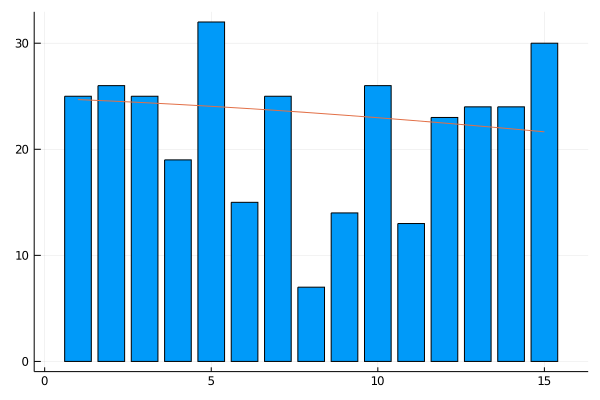

In [11]:
bar(
    obstimes,
    Y,
    legend=false
)
plot!(obstimes,X,legend=false)

In [12]:
pl = scatter(obstimes, Y, legend=false, xlabel="Time step", ylabel="Number of cases")
savefig(pl, "observedData.pdf")

## Model definition

In [13]:
# ╔═╡ d3a7154c-f36b-11ea-21f6-1569109c69eb
@model bayes_sir(y, total_population) = begin
    # Calculate number of timepoints
    l = length(y)
    i₀ ~ truncated(Normal(10, 10), 0, total_population/10)
    β ~ truncated(Normal(2, 1.5), 0, Inf)
    I = i₀ * 10.0
    u0=[total_population-I, I, 0.0, 0.0]
    p=[β, 0.25]
    tspan = (0.0,float(l))
    prob = ODEProblem(sir_ode!, u0, tspan, p)
    sol = solve(prob, Tsit5(), saveat = 1.0)
    sol_C = Array(sol)[4,:] # Cumulative cases
    sol_X = sol_C[2:end] - sol_C[1:(end-1)]

    l = length(y)
    if any(sol_X .< 0) || length(sol_X) != l 
    	# Check if we have negative cumulative cases
    	Turing.acclogp!(_varinfo, -Inf)
    	return l
    end

    phi = 0.5
    variance = sol_X .+ sol_X.^2 ./ phi
    rs = neg_bin_r.(sol_X, variance)
    ps = neg_bin_p.(rs, sol_X)
    if !all(rs .> 0) || !all(0 .< ps .<= 1)
        Turing.acclogp!(_varinfo, -Inf)
        @warn "This shouldn't happen" β i₀
        return l
    end
    
    y ~ arraydist(NegativeBinomial.(rs, ps))
    #y ~ arraydist([Poisson(x) for x in sol_X])
end

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /Users/reichelt/.julia/packages/DynamicPPL/moP7G/src/compiler.jl:169


bayes_sir (generic function with 1 method)

## Prior predictive

In [14]:
ode_prior = sample(bayes_sir(Y, total_population), Prior(), 1000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (1000×3×1 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = i₀, β
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
          i₀   12.9704    7.9931     0.2528    0.2987    961.1268    0.9990  
           β    2.2938    1.2852     0.0406    0.0349   1064.6857    0.9992  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
          i₀    0.7802    6.7610   12.0528   18.3303   30.5460  
           β    0.2233    1.3055    2.2108    3.1589    5.0170  


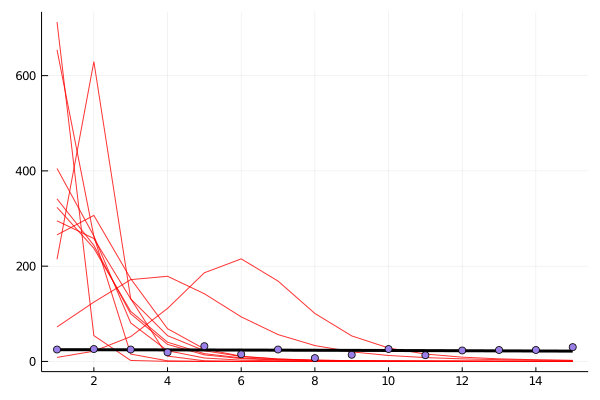

In [15]:
plot_predictive(obstimes, X, Y, ode_prior)

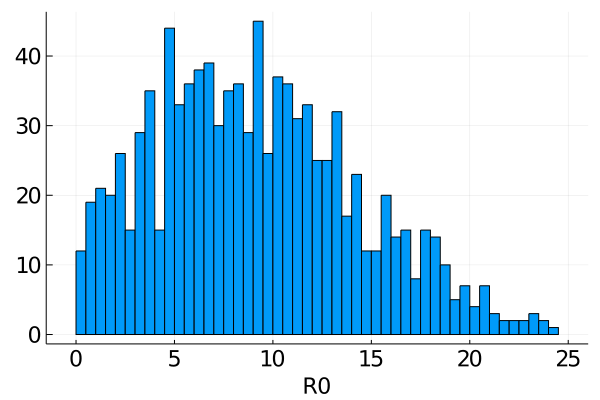

In [16]:
R0s = base_reproduction_rate.(Array(ode_prior[:β]), p[2])
pl = histogram(R0s, bins=50, legend=:false, xlabel="R0", guidefontsize=15, tickfontsize=15)
savefig(pl, "R0_prior_pred.pdf")
pl

In [17]:
ode_nuts = sample(bayes_sir(Y, total_population), NUTS(0.65), 10_000)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/reichelt/.julia/packages/Turing/RzDvB/src/inference/hmc.jl:625
┌ Warning: This shouldn't happen
│   β = Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:i₀, :β),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:i₀,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:i₀,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"#11#12",(:y, :total_population),(),(),Tuple{Array{Int64,1},Int64},Tuple{}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:i₀, :β),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{

Sampling:   1%|▌                                        |  ETA: 0:00:50┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/reichelt/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/reichelt/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/reichelt/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /Users/reichelt/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling:   2%|▊                         

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08


Chains MCMC chain (9000×14×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = i₀, β
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
          i₀   12.3028    6.6990     0.0706    0.1262   2570.7756    0.9999  
           β    0.2563    0.0553     0.0006    0.0012   2241.6319    0.9999  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
         

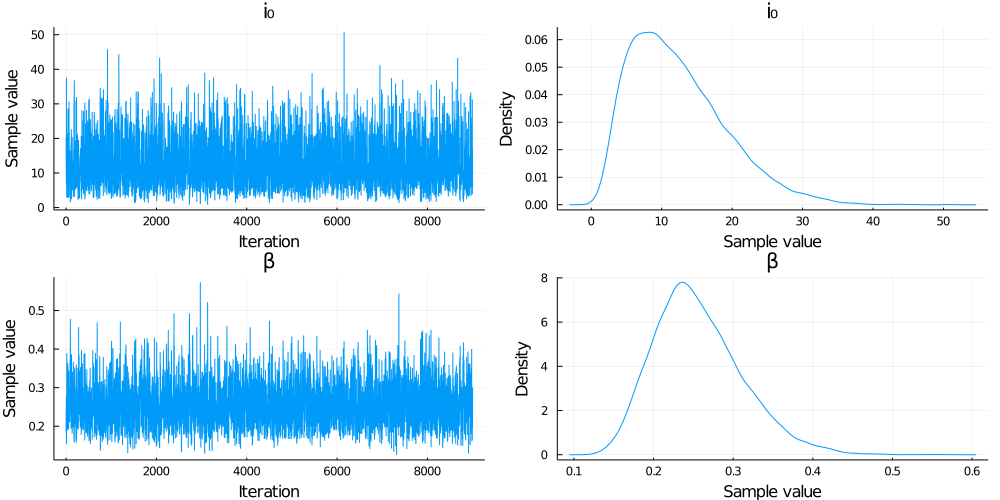

In [18]:
plot(ode_nuts)

In [19]:
sum(Array(ode_nuts[:numerical_error]) .!= 0)

8

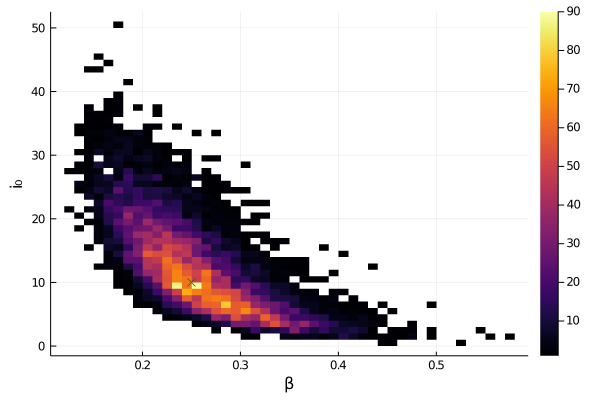

In [20]:
histogram2d( 
    Array(ode_nuts[:β]),
    Array(ode_nuts[:i₀]),
    bins=80,
    xlabel="β",
    ylabel="i₀"
)
scatter!([beta], [i0], marker=:x, legend=false, color=:green)

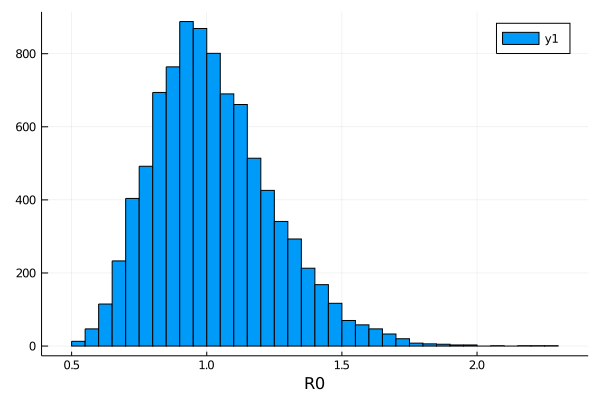

In [28]:
histogram(base_reproduction_rate.(Array(ode_nuts[:β]), p[2]), bins=80, xlabel="R0")

In [23]:
mean(cost_fn.(Array(ode_nuts[:β])))

55933.25626205024

In [24]:
posterior_betas = reshape(Array(ode_nuts[:β]), (9000,));

In [125]:
function plot_resamples(cost_fn, beta_samples)
    costs = cost_fn.(beta_samples)
    normalised_weights = costs ./ sum(costs)
    
    ess = 1 / sum(normalised_weights.^2)
    println("ESS of reweighted samples: $(ess)")

    betas_resampled = StatsBase.sample(beta_samples, pweights(normalised_weights), 9000)
    p2 = histogram(betas_resampled, bins=80, title="Resampled posterior samples", xlabel="beta", legend=false)
    p1 = histogram(beta_samples, bins=80, title="Posterior samples", xlabel="beta", legend=false)
    return plot(p1, p2, layout=(2,1), link=:x)
end

plot_resamples (generic function with 1 method)

ESS of reweighted samples: 1224.4124168619846


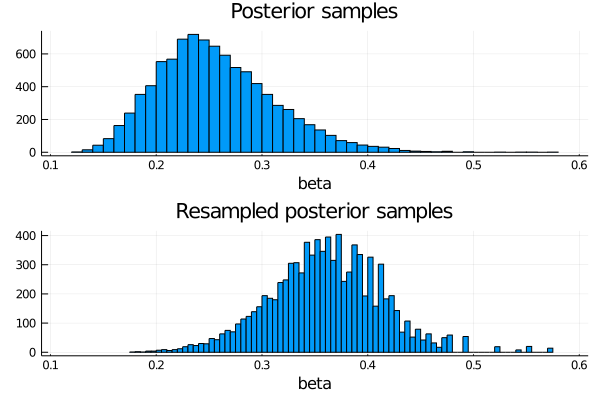

In [126]:
plot_resamples(cost_fn, posterior_betas)

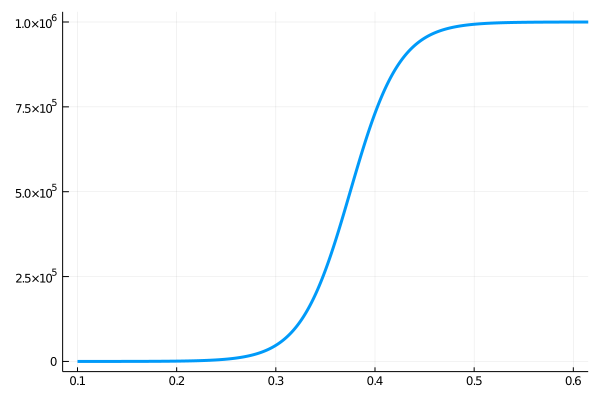

In [33]:
xs = collect(range(0.1,0.7, length=1000))
plot(xs, cost_fn.(xs), lw=3, legend=false, xlims=[0.1,0.6])

## Extreme cost function

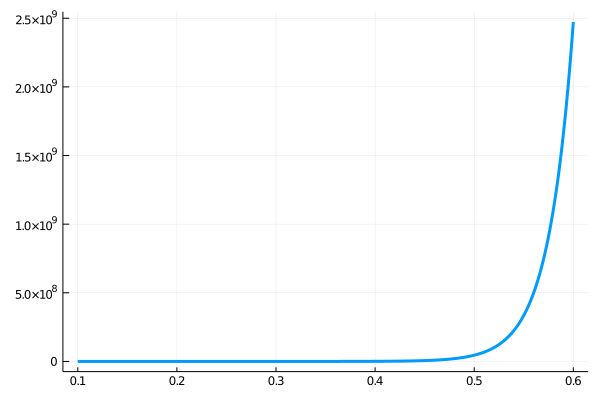

In [134]:
cost_fn2(x; k=1) = 1_000_000_000_000 * logistic(k*(10*base_reproduction_rate(x, gamma) - 30))
xs = collect(range(0.1,0.6, length=1000))
plot(xs, cost_fn2.(xs), lw=3, legend=false, xlims=[0.1,0.6])

ESS of reweighted samples: 5.42292853693431


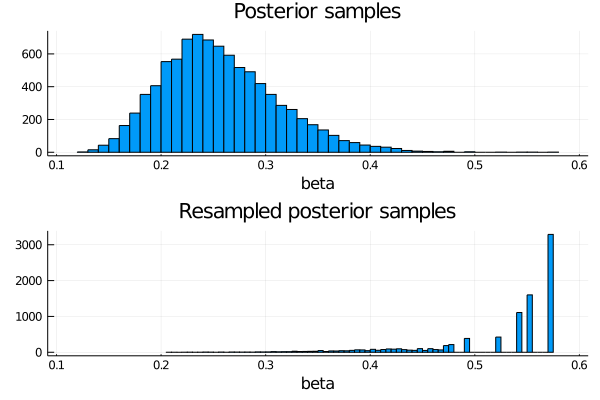

In [135]:
plot_resamples(cost_fn2, posterior_betas)

## Importance Sampling

In [138]:
spl = Turing.Sampler(NUTS(0.65), bayes_sir(Y, total_population))
logjoint = gen_logjoint(spl.state.vi, bayes_sir(Y, total_population), spl)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/reichelt/.julia/packages/Turing/RzDvB/src/inference/hmc.jl:625


logjoint (generic function with 1 method)

### Target posterior

In [207]:
function is_sampling(logjoint, qi, qb)
    qb_samples = rand(qb, 1000)
    qi_samples = rand(qi, 1000)
    q_samples = zip(qi_samples, qb_samples)
    qb_weights = logpdf.(qb, qb_samples)
    is_weights = logjoint.(q_samples) - (logpdf.(qi, qi_samples) .+ logpdf.(qb, qb_samples))
    normalised_is_weights = is_weights .- logsumexp(is_weights)
    
    ess = 1 / exp(logsumexp(2 * normalised_is_weights))
    println("ESS: $(ess)")

    return scatter(
        qb_samples, 
        normalised_is_weights, 
        markersize=3, 
        markeralpha=0.4, 
        legend=false, 
        ylims=[-25,0]
    )
end

is_sampling (generic function with 1 method)

ESS: 52.25817079421182


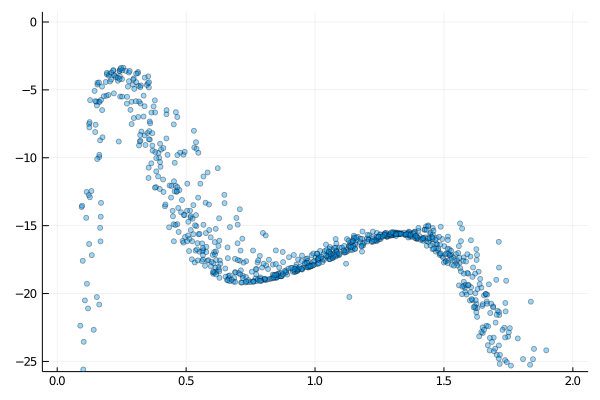

In [211]:
qi = truncated(Normal(10, 10), 0, total_population/10)
qb = Uniform(0,2)

is_sampling(logjoint, qi, qb)

### Target posterior * f(x)

ESS: 147.48511691344962


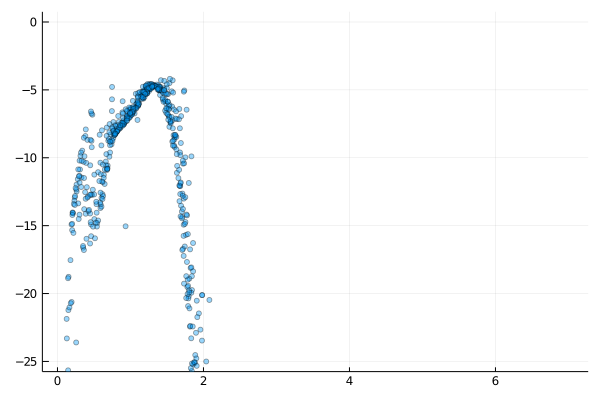

In [206]:
qb = truncated(Normal(1.5, 1.5), 0, Inf)
qb_samples = rand(qb, 1000)
qi_samples = rand(qi, 1000)
q_samples = zip(qi_samples, qb_samples)
qb_weights = logpdf.(qb, qb_samples)
is_weights = (logjoint.(q_samples) + log.(cost_fn2.(qb_samples))) - (logpdf.(qi, qi_samples) .+ logpdf.(qb, qb_samples))
normalised_is_weights = is_weights .- logsumexp(is_weights)

ess = 1 / exp(logsumexp(2 * normalised_is_weights))
println("ESS: $(ess)")
scatter(qb_samples, normalised_is_weights, markersize=3, markeralpha=0.4, legend=false, ylims=[-25,0])